# Training From Scratch Multi
Entrainement du modèle DenseNet201 13 bandes sans poids pré entrainé pour café contre reste et culture contre non-culture

* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [5]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from focal_loss import BinaryFocalLoss
from keras import backend as K 
from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.tools import *
from IAdeforestation.spatial_cross_val import * 

In [6]:
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

In [7]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7951359945304251084
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7705100288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4320707882027328810
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Define model

In [8]:
base_model = DenseNet201(
    include_top=False,
    weights=None,
    input_shape=(64,64,13),
    pooling=None,
)
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [9]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(base_model.layers[-1].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(1, activation='sigmoid')(dropout32)

    return Model(inputs=base_model.input, outputs=output)

In [10]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'from_scratch')

# Coffee vs other

In [7]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold_32', 'train_data_32.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

### Compute class weight

In [8]:
nb_0 = len(all_data[all_data['label']==0])
nb_1 = len(all_data[all_data['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

### Train

In [11]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_spacv_10FOLD_coffee_32_1'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

Fold 1 Number coffee - train : 769
Fold 1 Number no-coffee - train : 1958
Fold 1 Number coffee - val : 173
Fold 1 Number no-coffee - val : 166
Training for fold 1
-----
Epoch 1/100
126/126 [==============================] - 33s 143ms/step - loss: 1.3471 - accuracy: 0.5872 - precision: 0.7567 - recall: 0.6274 - f1_score_keras: 0.6844 - val_loss: 0.9526 - val_accuracy: 0.4594 - val_precision: 0.4645 - val_recall: 0.5903 - val_f1_score_keras: 0.5169
Epoch 2/100
126/126 [==============================] - 16s 125ms/step - loss: 1.0562 - accuracy: 0.6639 - precision: 0.8156 - recall: 0.6930 - f1_score_keras: 0.7482 - val_loss: 0.9756 - val_accuracy: 0.5427 - val_precision: 0.5786 - val_recall: 0.3963 - val_f1_score_keras: 0.4684
Epoch 3/100
126/126 [==============================] - 16s 125ms/step - loss: 0.9726 - accuracy: 0.7120 - precision: 0.8519 - recall: 0.7305 - f1_score_keras: 0.7856 - val_loss: 1.0369 - val_accuracy: 0.6094 - val_precision: 0.6610 - val_recall: 0.4115 - val_f1_score

Epoch 58/100
126/126 [==============================] - 16s 126ms/step - loss: 0.4294 - accuracy: 0.9366 - precision: 0.9836 - recall: 0.9263 - f1_score_keras: 0.9539 - val_loss: 1.4554 - val_accuracy: 0.7135 - val_precision: 0.8149 - val_recall: 0.5617 - val_f1_score_keras: 0.6638
Epoch 59/100
126/126 [==============================] - 16s 126ms/step - loss: 0.4284 - accuracy: 0.9382 - precision: 0.9813 - recall: 0.9313 - f1_score_keras: 0.9554 - val_loss: 1.4222 - val_accuracy: 0.6687 - val_precision: 0.7373 - val_recall: 0.5556 - val_f1_score_keras: 0.6311
Epoch 60/100
126/126 [==============================] - 16s 126ms/step - loss: 0.4200 - accuracy: 0.9393 - precision: 0.9829 - recall: 0.9324 - f1_score_keras: 0.9569 - val_loss: 1.5434 - val_accuracy: 0.6542 - val_precision: 0.7118 - val_recall: 0.5157 - val_f1_score_keras: 0.5968
Epoch 61/100
126/126 [==============================] - 16s 126ms/step - loss: 0.4128 - accuracy: 0.9437 - precision: 0.9833 - recall: 0.9379 - f1_scor

Epoch 87/100
126/126 [==============================] - 16s 125ms/step - loss: 0.3570 - accuracy: 0.9567 - precision: 0.9893 - recall: 0.9512 - f1_score_keras: 0.9702 - val_loss: 1.5706 - val_accuracy: 0.7010 - val_precision: 0.7285 - val_recall: 0.5930 - val_f1_score_keras: 0.6518
Epoch 88/100
126/126 [==============================] - 16s 126ms/step - loss: 0.3612 - accuracy: 0.9608 - precision: 0.9852 - recall: 0.9602 - f1_score_keras: 0.9724 - val_loss: 1.5124 - val_accuracy: 0.7229 - val_precision: 0.8040 - val_recall: 0.5849 - val_f1_score_keras: 0.6712
Epoch 89/100
126/126 [==============================] - 16s 126ms/step - loss: 0.3405 - accuracy: 0.9674 - precision: 0.9930 - recall: 0.9609 - f1_score_keras: 0.9767 - val_loss: 1.6950 - val_accuracy: 0.6865 - val_precision: 0.7293 - val_recall: 0.5653 - val_f1_score_keras: 0.6352
Epoch 90/100
126/126 [==============================] - 16s 125ms/step - loss: 0.3398 - accuracy: 0.9668 - precision: 0.9911 - recall: 0.9627 - f1_scor

Epoch 13/100
123/123 [==============================] - 15s 126ms/step - loss: 0.4101 - accuracy: 0.9513 - precision: 0.9848 - recall: 0.9473 - f1_score_keras: 0.9656 - val_loss: 0.4367 - val_accuracy: 0.9344 - val_precision: 0.8875 - val_recall: 0.9980 - val_f1_score_keras: 0.9392
Epoch 14/100
123/123 [==============================] - 15s 126ms/step - loss: 0.4125 - accuracy: 0.9574 - precision: 0.9838 - recall: 0.9565 - f1_score_keras: 0.9696 - val_loss: 0.3769 - val_accuracy: 0.9677 - val_precision: 0.9491 - val_recall: 0.9898 - val_f1_score_keras: 0.9682
Epoch 15/100
123/123 [==============================] - 15s 126ms/step - loss: 0.4319 - accuracy: 0.9548 - precision: 0.9835 - recall: 0.9529 - f1_score_keras: 0.9679 - val_loss: 0.4184 - val_accuracy: 0.9438 - val_precision: 0.9102 - val_recall: 0.9922 - val_f1_score_keras: 0.9486
Epoch 16/100
123/123 [==============================] - 16s 128ms/step - loss: 0.4003 - accuracy: 0.9605 - precision: 0.9877 - recall: 0.9560 - f1_scor

Epoch 42/100
123/123 [==============================] - 16s 127ms/step - loss: 0.3390 - accuracy: 0.9757 - precision: 0.9922 - recall: 0.9734 - f1_score_keras: 0.9828 - val_loss: 0.6236 - val_accuracy: 0.8927 - val_precision: 0.8215 - val_recall: 1.0000 - val_f1_score_keras: 0.9019
Epoch 43/100
123/123 [==============================] - 16s 127ms/step - loss: 0.3299 - accuracy: 0.9772 - precision: 0.9925 - recall: 0.9750 - f1_score_keras: 0.9834 - val_loss: 0.6475 - val_accuracy: 0.8865 - val_precision: 0.8257 - val_recall: 0.9941 - val_f1_score_keras: 0.9020
Epoch 44/100
123/123 [==============================] - 15s 126ms/step - loss: 0.3528 - accuracy: 0.9711 - precision: 0.9911 - recall: 0.9681 - f1_score_keras: 0.9796 - val_loss: 0.5948 - val_accuracy: 0.9010 - val_precision: 0.8445 - val_recall: 0.9961 - val_f1_score_keras: 0.9139
Epoch 45/100
123/123 [==============================] - 15s 126ms/step - loss: 0.3495 - accuracy: 0.9715 - precision: 0.9929 - recall: 0.9676 - f1_scor

Epoch 71/100
123/123 [==============================] - 16s 128ms/step - loss: 0.2984 - accuracy: 0.9810 - precision: 0.9927 - recall: 0.9809 - f1_score_keras: 0.9867 - val_loss: 0.5762 - val_accuracy: 0.9031 - val_precision: 0.8364 - val_recall: 0.9935 - val_f1_score_keras: 0.9081
Epoch 72/100
123/123 [==============================] - 16s 126ms/step - loss: 0.2901 - accuracy: 0.9861 - precision: 0.9953 - recall: 0.9854 - f1_score_keras: 0.9903 - val_loss: 0.6182 - val_accuracy: 0.9000 - val_precision: 0.8505 - val_recall: 0.9884 - val_f1_score_keras: 0.9143
Epoch 73/100
123/123 [==============================] - 15s 126ms/step - loss: 0.2885 - accuracy: 0.9828 - precision: 0.9960 - recall: 0.9799 - f1_score_keras: 0.9878 - val_loss: 0.7473 - val_accuracy: 0.8760 - val_precision: 0.7953 - val_recall: 0.9865 - val_f1_score_keras: 0.8802
Epoch 74/100
123/123 [==============================] - 16s 126ms/step - loss: 0.2855 - accuracy: 0.9852 - precision: 0.9963 - recall: 0.9831 - f1_scor

Epoch 100/100
4/4 [==============================] - 0s 99ms/step - loss: 0.7058 - accuracy: 0.9023 - precision: 0.8503 - recall: 0.9766 - f1_score_keras: 0.9074
Fold 2 loss : 0.7057641744613647
Fold 2 accuracy : 0.90234375
Fold 2 F1-score : 0.9073690176010132
1/1 [==============================] - 2s 2s/step - loss: 0.7056 - accuracy: 0.8930 - precision: 0.8291 - recall: 0.9949 - f1_score_keras: 0.9044
[[145  43]
 [  3 192]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       188
           1       0.82      0.98      0.89       195

    accuracy                           0.88       383
   macro avg       0.90      0.88      0.88       383
weighted avg       0.90      0.88      0.88       383

F1-Score : 0.8930232558139535


Fold 3 Number coffee - train : 723
Fold 3 Number no-coffee - train : 1663
Fold 3 Number coffee - val : 219
Fold 3 Number no-coffee - val : 461
Training for fold 3
-----
Epoch 1/100
111/111 [=====================

Epoch 26/100
111/111 [==============================] - 16s 142ms/step - loss: 0.3099 - accuracy: 0.9914 - precision: 0.9959 - recall: 0.9917 - f1_score_keras: 0.9938 - val_loss: 0.9057 - val_accuracy: 0.8891 - val_precision: 0.9843 - val_recall: 0.8525 - val_f1_score_keras: 0.9125
Epoch 27/100
111/111 [==============================] - 16s 141ms/step - loss: 0.3042 - accuracy: 0.9931 - precision: 0.9978 - recall: 0.9922 - f1_score_keras: 0.9949 - val_loss: 0.7389 - val_accuracy: 0.9010 - val_precision: 0.9956 - val_recall: 0.8597 - val_f1_score_keras: 0.9226
Epoch 28/100
111/111 [==============================] - 16s 142ms/step - loss: 0.3079 - accuracy: 0.9892 - precision: 0.9951 - recall: 0.9893 - f1_score_keras: 0.9922 - val_loss: 1.0940 - val_accuracy: 0.8578 - val_precision: 0.9931 - val_recall: 0.7915 - val_f1_score_keras: 0.8793
Epoch 29/100
111/111 [==============================] - 16s 142ms/step - loss: 0.3122 - accuracy: 0.9892 - precision: 0.9943 - recall: 0.9902 - f1_scor

Epoch 55/100
111/111 [==============================] - 16s 142ms/step - loss: 0.2752 - accuracy: 0.9920 - precision: 0.9981 - recall: 0.9906 - f1_score_keras: 0.9944 - val_loss: 1.2788 - val_accuracy: 0.8510 - val_precision: 0.9882 - val_recall: 0.7861 - val_f1_score_keras: 0.8740
Epoch 56/100
111/111 [==============================] - 16s 142ms/step - loss: 0.2785 - accuracy: 0.9909 - precision: 0.9954 - recall: 0.9913 - f1_score_keras: 0.9934 - val_loss: 1.6077 - val_accuracy: 0.8130 - val_precision: 0.9898 - val_recall: 0.7350 - val_f1_score_keras: 0.8426
Epoch 57/100
111/111 [==============================] - 16s 142ms/step - loss: 0.2892 - accuracy: 0.9909 - precision: 0.9947 - recall: 0.9921 - f1_score_keras: 0.9934 - val_loss: 1.2403 - val_accuracy: 0.8365 - val_precision: 0.9839 - val_recall: 0.7666 - val_f1_score_keras: 0.8600
Epoch 58/100
111/111 [==============================] - 16s 142ms/step - loss: 0.2699 - accuracy: 0.9932 - precision: 0.9965 - recall: 0.9933 - f1_scor

Epoch 84/100
111/111 [==============================] - 16s 142ms/step - loss: 0.2315 - accuracy: 0.9962 - precision: 0.9991 - recall: 0.9952 - f1_score_keras: 0.9971 - val_loss: 1.3585 - val_accuracy: 0.8302 - val_precision: 0.9979 - val_recall: 0.7461 - val_f1_score_keras: 0.8519
Epoch 85/100
111/111 [==============================] - 16s 142ms/step - loss: 0.2294 - accuracy: 0.9955 - precision: 0.9981 - recall: 0.9955 - f1_score_keras: 0.9969 - val_loss: 1.1633 - val_accuracy: 0.8344 - val_precision: 0.9920 - val_recall: 0.7614 - val_f1_score_keras: 0.8609
Epoch 86/100
111/111 [==============================] - 16s 142ms/step - loss: 0.2315 - accuracy: 0.9966 - precision: 0.9985 - recall: 0.9966 - f1_score_keras: 0.9975 - val_loss: 1.3240 - val_accuracy: 0.8255 - val_precision: 0.9968 - val_recall: 0.7386 - val_f1_score_keras: 0.8461
Epoch 87/100
111/111 [==============================] - 16s 143ms/step - loss: 0.2273 - accuracy: 0.9960 - precision: 0.9992 - recall: 0.9952 - f1_scor

Epoch 13/100
102/102 [==============================] - 15s 151ms/step - loss: 0.3573 - accuracy: 0.9796 - precision: 0.9931 - recall: 0.9751 - f1_score_keras: 0.9839 - val_loss: 0.3276 - val_accuracy: 0.9844 - val_precision: 0.9968 - val_recall: 0.9841 - val_f1_score_keras: 0.9903
Epoch 14/100
102/102 [==============================] - 15s 151ms/step - loss: 0.3504 - accuracy: 0.9790 - precision: 0.9950 - recall: 0.9721 - f1_score_keras: 0.9838 - val_loss: 0.3626 - val_accuracy: 0.9735 - val_precision: 0.9951 - val_recall: 0.9726 - val_f1_score_keras: 0.9836
Epoch 15/100
102/102 [==============================] - 15s 152ms/step - loss: 0.3522 - accuracy: 0.9792 - precision: 0.9963 - recall: 0.9716 - f1_score_keras: 0.9841 - val_loss: 0.3570 - val_accuracy: 0.9779 - val_precision: 0.9962 - val_recall: 0.9767 - val_f1_score_keras: 0.9863
Epoch 16/100
102/102 [==============================] - 15s 152ms/step - loss: 0.3500 - accuracy: 0.9820 - precision: 0.9945 - recall: 0.9774 - f1_scor

Epoch 42/100
102/102 [==============================] - 15s 152ms/step - loss: 0.3004 - accuracy: 0.9905 - precision: 0.9965 - recall: 0.9890 - f1_score_keras: 0.9927 - val_loss: 0.3228 - val_accuracy: 0.9826 - val_precision: 0.9942 - val_recall: 0.9850 - val_f1_score_keras: 0.9893
Epoch 43/100
102/102 [==============================] - 15s 152ms/step - loss: 0.2942 - accuracy: 0.9905 - precision: 0.9979 - recall: 0.9875 - f1_score_keras: 0.9926 - val_loss: 0.3362 - val_accuracy: 0.9727 - val_precision: 0.9952 - val_recall: 0.9720 - val_f1_score_keras: 0.9833
Epoch 44/100
102/102 [==============================] - 15s 151ms/step - loss: 0.2968 - accuracy: 0.9892 - precision: 0.9968 - recall: 0.9862 - f1_score_keras: 0.9913 - val_loss: 0.3339 - val_accuracy: 0.9761 - val_precision: 0.9995 - val_recall: 0.9722 - val_f1_score_keras: 0.9854
Epoch 45/100
102/102 [==============================] - 15s 151ms/step - loss: 0.2989 - accuracy: 0.9872 - precision: 0.9959 - recall: 0.9841 - f1_scor

Epoch 71/100
102/102 [==============================] - 15s 151ms/step - loss: 0.2697 - accuracy: 0.9901 - precision: 0.9958 - recall: 0.9884 - f1_score_keras: 0.9920 - val_loss: 0.5111 - val_accuracy: 0.9188 - val_precision: 0.9943 - val_recall: 0.9073 - val_f1_score_keras: 0.9485
Epoch 72/100
102/102 [==============================] - 15s 150ms/step - loss: 0.2618 - accuracy: 0.9898 - precision: 0.9969 - recall: 0.9870 - f1_score_keras: 0.9920 - val_loss: 0.4049 - val_accuracy: 0.9444 - val_precision: 0.9951 - val_recall: 0.9386 - val_f1_score_keras: 0.9657
Epoch 73/100
102/102 [==============================] - 15s 152ms/step - loss: 0.2516 - accuracy: 0.9945 - precision: 0.9976 - recall: 0.9938 - f1_score_keras: 0.9957 - val_loss: 0.3726 - val_accuracy: 0.9557 - val_precision: 0.9961 - val_recall: 0.9501 - val_f1_score_keras: 0.9724
Epoch 74/100
102/102 [==============================] - 15s 151ms/step - loss: 0.2708 - accuracy: 0.9887 - precision: 0.9957 - recall: 0.9865 - f1_scor

Epoch 21/100
102/102 [==============================] - 16s 155ms/step - loss: 0.3334 - accuracy: 0.9860 - precision: 0.9955 - recall: 0.9838 - f1_score_keras: 0.9896 - val_loss: 0.6000 - val_accuracy: 0.9123 - val_precision: 0.8987 - val_recall: 0.9924 - val_f1_score_keras: 0.9428
Epoch 22/100
102/102 [==============================] - 16s 155ms/step - loss: 0.3532 - accuracy: 0.9813 - precision: 0.9898 - recall: 0.9822 - f1_score_keras: 0.9860 - val_loss: 0.5389 - val_accuracy: 0.9227 - val_precision: 0.9123 - val_recall: 0.9878 - val_f1_score_keras: 0.9480
Epoch 23/100
102/102 [==============================] - 16s 153ms/step - loss: 0.3255 - accuracy: 0.9862 - precision: 0.9929 - recall: 0.9865 - f1_score_keras: 0.9895 - val_loss: 0.4826 - val_accuracy: 0.9391 - val_precision: 0.9267 - val_recall: 0.9956 - val_f1_score_keras: 0.9599
Epoch 24/100
102/102 [==============================] - 16s 154ms/step - loss: 0.3232 - accuracy: 0.9870 - precision: 0.9940 - recall: 0.9870 - f1_scor

Epoch 50/100
102/102 [==============================] - 16s 154ms/step - loss: 0.2996 - accuracy: 0.9893 - precision: 0.9952 - recall: 0.9890 - f1_score_keras: 0.9921 - val_loss: 0.5110 - val_accuracy: 0.9335 - val_precision: 0.9230 - val_recall: 0.9924 - val_f1_score_keras: 0.9564
Epoch 51/100
102/102 [==============================] - 16s 154ms/step - loss: 0.2937 - accuracy: 0.9900 - precision: 0.9954 - recall: 0.9895 - f1_score_keras: 0.9924 - val_loss: 0.4999 - val_accuracy: 0.9403 - val_precision: 0.9293 - val_recall: 0.9946 - val_f1_score_keras: 0.9606
Epoch 52/100
102/102 [==============================] - 16s 154ms/step - loss: 0.2822 - accuracy: 0.9929 - precision: 0.9981 - recall: 0.9915 - f1_score_keras: 0.9948 - val_loss: 0.5425 - val_accuracy: 0.9243 - val_precision: 0.9139 - val_recall: 0.9908 - val_f1_score_keras: 0.9505
Epoch 53/100
102/102 [==============================] - 16s 155ms/step - loss: 0.2993 - accuracy: 0.9914 - precision: 0.9973 - recall: 0.9898 - f1_scor

Epoch 79/100
102/102 [==============================] - 16s 155ms/step - loss: 0.2589 - accuracy: 0.9926 - precision: 0.9978 - recall: 0.9910 - f1_score_keras: 0.9944 - val_loss: 0.4541 - val_accuracy: 0.9323 - val_precision: 0.9182 - val_recall: 0.9967 - val_f1_score_keras: 0.9556
Epoch 80/100
102/102 [==============================] - 16s 154ms/step - loss: 0.2449 - accuracy: 0.9948 - precision: 0.9983 - recall: 0.9939 - f1_score_keras: 0.9961 - val_loss: 0.5585 - val_accuracy: 0.9215 - val_precision: 0.9088 - val_recall: 0.9929 - val_f1_score_keras: 0.9484
Epoch 81/100
102/102 [==============================] - 16s 155ms/step - loss: 0.2517 - accuracy: 0.9933 - precision: 0.9977 - recall: 0.9925 - f1_score_keras: 0.9952 - val_loss: 0.6779 - val_accuracy: 0.8874 - val_precision: 0.8767 - val_recall: 0.9835 - val_f1_score_keras: 0.9265
Epoch 82/100
102/102 [==============================] - 16s 154ms/step - loss: 0.2477 - accuracy: 0.9938 - precision: 0.9979 - recall: 0.9929 - f1_scor

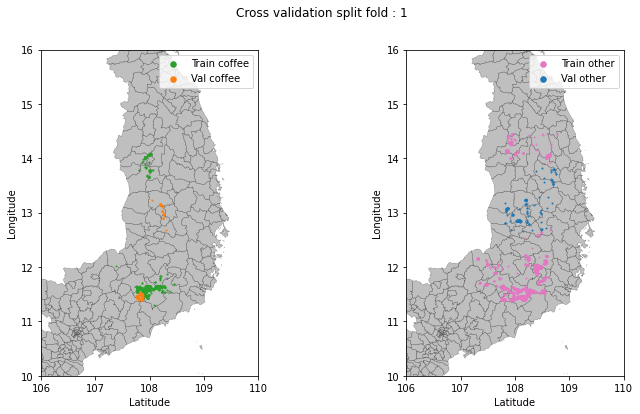

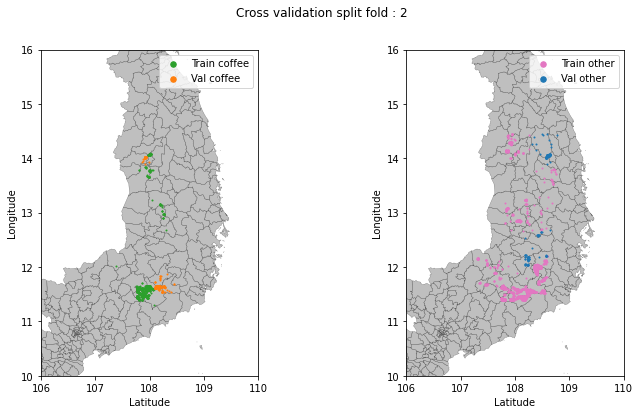

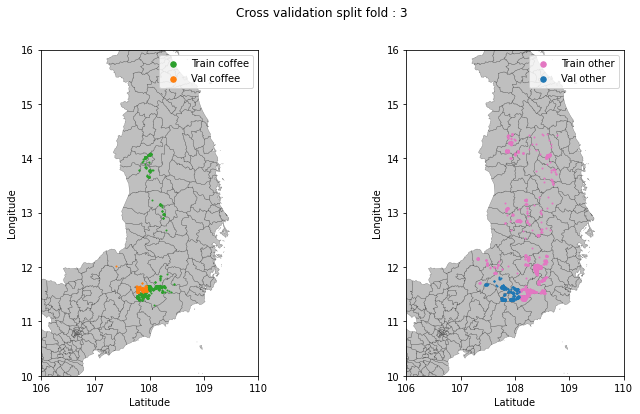

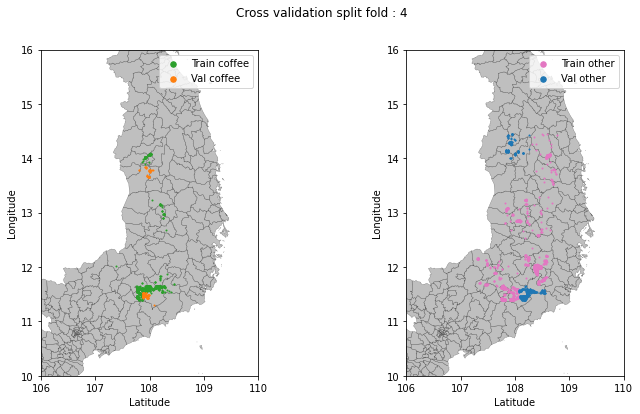

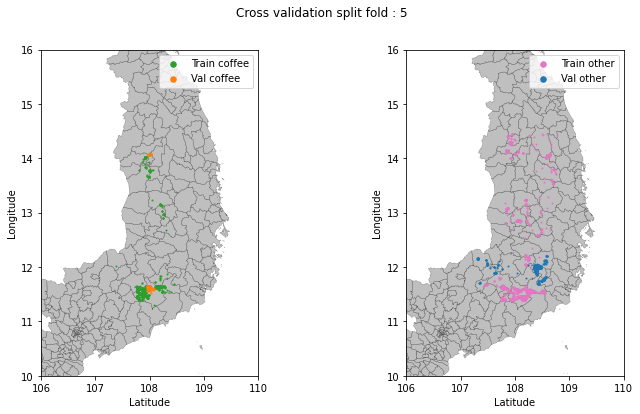

In [12]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold_32",f"train_{i_fold+1}_data_32.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold_32",f"val_{i_fold+1}_data_32.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i_fold+1}")
    
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=len(geo_val)//BATCH_SIZE,
                        callbacks=[earlystopper],
                        class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)
    
    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [13]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [14]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.8625
Stdev accuracy : 0.11459102720381295


Mean loss : 0.9477930307388306
Stdev loss : 0.6356763925434789


Mean precision : 0.8856002569198609
Stdev precision : 0.1356699537134363


Mean recall : 0.8420120000839233
Stdev recall : 0.18539092439810598


Mean F1-Score : 0.8576128840446472
Stdev F1-Score : 0.15398819206127154


## Loss and accs plots

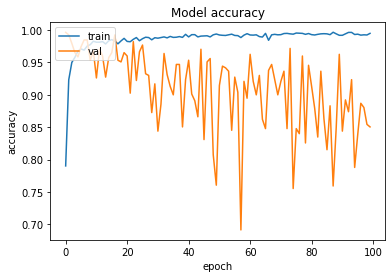

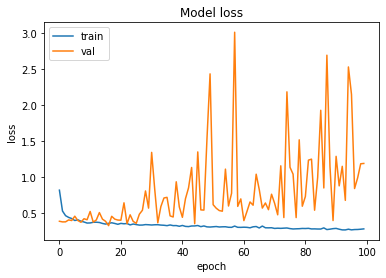

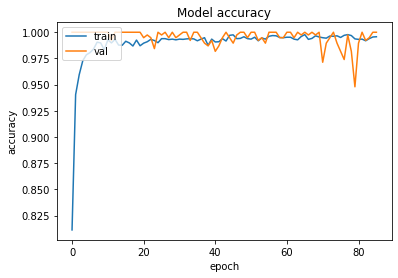

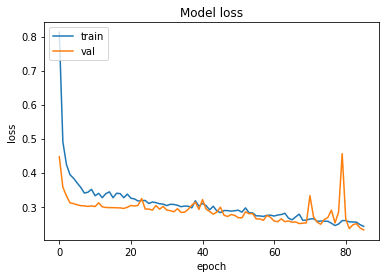

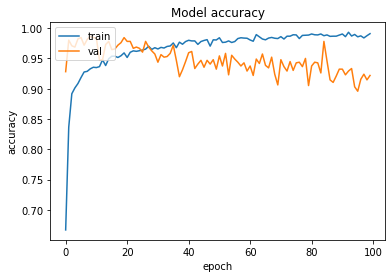

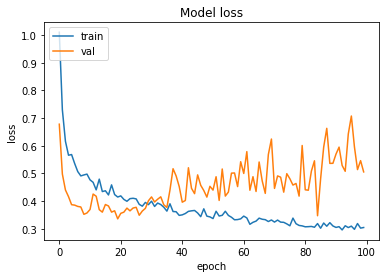

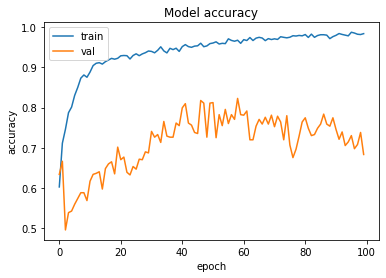

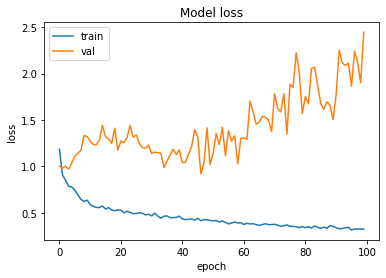

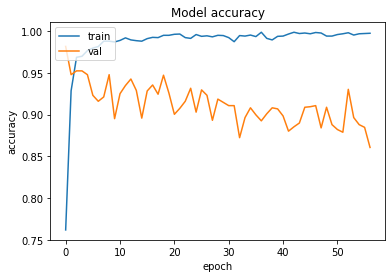

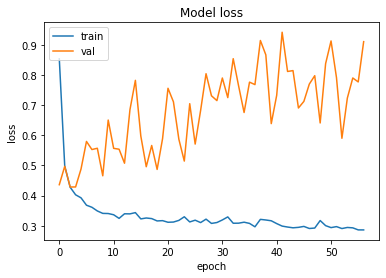

In [16]:
a = os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_spacv_10FOLD_coffee2')
for i in os.listdir(a):
    if(i.split('.')[1] == 'npy'):
        chart = np.load(os.path.join(a, i), allow_pickle=True).item()
        
        # summarize history for accuracy
        plt.plot(chart['accuracy'])
        plt.plot(chart['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(chart['loss'])
        plt.plot(chart['val_loss'])
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

# Culture vs no-culture
### Train model

In [13]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'final_spacv_10FOLD_culture_1'
NB_FOLD = 5

results= []

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

In [15]:
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

Fold 1 Number culture - train : 752
Fold 1 Number no-culture - train : 566
Fold 1 Number culture - val : 72
Fold 1 Number no-culture - val : 72
Training for fold 1
-----
Epoch 1/100
40/40 [==============================] - 23s 203ms/step - loss: 1.0423 - accuracy: 0.6495 - precision: 0.6159 - recall: 0.5913 - f1_score_keras: 0.5971 - val_loss: 0.9511 - val_accuracy: 0.7383 - val_precision: 0.9815 - val_recall: 0.4454 - val_f1_score_keras: 0.6140
Epoch 2/100
40/40 [==============================] - 6s 142ms/step - loss: 0.6264 - accuracy: 0.8856 - precision: 0.8865 - recall: 0.8516 - f1_score_keras: 0.8679 - val_loss: 0.8921 - val_accuracy: 0.7461 - val_precision: 0.9848 - val_recall: 0.5039 - val_f1_score_keras: 0.6634
Epoch 3/100
40/40 [==============================] - 6s 144ms/step - loss: 0.5763 - accuracy: 0.9070 - precision: 0.9160 - recall: 0.8617 - f1_score_keras: 0.8890 - val_loss: 0.8207 - val_accuracy: 0.7812 - val_precision: 1.0000 - val_recall: 0.5852 - val_f1_score_keras:

Epoch 30/100
40/40 [==============================] - 6s 142ms/step - loss: 0.3288 - accuracy: 0.9761 - precision: 0.9806 - recall: 0.9637 - f1_score_keras: 0.9718 - val_loss: 0.9131 - val_accuracy: 0.7891 - val_precision: 0.8505 - val_recall: 0.7054 - val_f1_score_keras: 0.7693
Epoch 31/100
40/40 [==============================] - 6s 145ms/step - loss: 0.3098 - accuracy: 0.9784 - precision: 0.9811 - recall: 0.9675 - f1_score_keras: 0.9751 - val_loss: 1.0608 - val_accuracy: 0.7969 - val_precision: 0.8830 - val_recall: 0.6694 - val_f1_score_keras: 0.7582
Epoch 32/100
40/40 [==============================] - 6s 144ms/step - loss: 0.3341 - accuracy: 0.9666 - precision: 0.9802 - recall: 0.9430 - f1_score_keras: 0.9612 - val_loss: 1.1834 - val_accuracy: 0.7539 - val_precision: 0.8830 - val_recall: 0.6148 - val_f1_score_keras: 0.7252
Epoch 33/100
40/40 [==============================] - 6s 147ms/step - loss: 0.2957 - accuracy: 0.9754 - precision: 0.9698 - recall: 0.9744 - f1_score_keras: 0.9

40/40 [==============================] - 6s 145ms/step - loss: 0.1972 - accuracy: 0.9690 - precision: 0.9664 - recall: 0.9569 - f1_score_keras: 0.9604 - val_loss: 1.3034 - val_accuracy: 0.7773 - val_precision: 0.7963 - val_recall: 0.7107 - val_f1_score_keras: 0.7507
Epoch 89/100
40/40 [==============================] - 6s 140ms/step - loss: 0.1430 - accuracy: 0.9852 - precision: 0.9918 - recall: 0.9747 - f1_score_keras: 0.9826 - val_loss: 1.4766 - val_accuracy: 0.8086 - val_precision: 0.8544 - val_recall: 0.7213 - val_f1_score_keras: 0.7807
Epoch 90/100
40/40 [==============================] - 6s 146ms/step - loss: 0.1277 - accuracy: 0.9889 - precision: 0.9846 - recall: 0.9881 - f1_score_keras: 0.9863 - val_loss: 0.7826 - val_accuracy: 0.8672 - val_precision: 0.8889 - val_recall: 0.8320 - val_f1_score_keras: 0.8595
Epoch 91/100
40/40 [==============================] - 6s 145ms/step - loss: 0.1747 - accuracy: 0.9791 - precision: 0.9792 - recall: 0.9733 - f1_score_keras: 0.9764 - val_los

Epoch 14/100
38/38 [==============================] - 6s 148ms/step - loss: 0.2640 - accuracy: 0.9918 - precision: 0.9898 - recall: 0.9897 - f1_score_keras: 0.9897 - val_loss: 0.4856 - val_accuracy: 0.9167 - val_precision: 0.9953 - val_recall: 0.8730 - val_f1_score_keras: 0.9301
Epoch 15/100
38/38 [==============================] - 6s 150ms/step - loss: 0.2621 - accuracy: 0.9887 - precision: 0.9928 - recall: 0.9792 - f1_score_keras: 0.9860 - val_loss: 0.4984 - val_accuracy: 0.9245 - val_precision: 0.9849 - val_recall: 0.8829 - val_f1_score_keras: 0.9305
Epoch 16/100
38/38 [==============================] - 6s 152ms/step - loss: 0.2493 - accuracy: 0.9901 - precision: 0.9899 - recall: 0.9857 - f1_score_keras: 0.9872 - val_loss: 0.7553 - val_accuracy: 0.8906 - val_precision: 0.9744 - val_recall: 0.8370 - val_f1_score_keras: 0.8987
Epoch 17/100
38/38 [==============================] - 6s 150ms/step - loss: 0.2516 - accuracy: 0.9879 - precision: 0.9866 - recall: 0.9817 - f1_score_keras: 0.9

Epoch 2/100
36/36 [==============================] - 6s 155ms/step - loss: 0.3307 - accuracy: 0.9884 - precision: 0.9907 - recall: 0.9853 - f1_score_keras: 0.9884 - val_loss: 0.4222 - val_accuracy: 0.9551 - val_precision: 0.8623 - val_recall: 0.9675 - val_f1_score_keras: 0.9113
Epoch 3/100
36/36 [==============================] - 6s 160ms/step - loss: 0.3242 - accuracy: 0.9914 - precision: 0.9976 - recall: 0.9850 - f1_score_keras: 0.9912 - val_loss: 0.3169 - val_accuracy: 0.9902 - val_precision: 0.9820 - val_recall: 0.9732 - val_f1_score_keras: 0.9766
Epoch 4/100
36/36 [==============================] - 6s 155ms/step - loss: 0.3049 - accuracy: 0.9924 - precision: 0.9920 - recall: 0.9920 - f1_score_keras: 0.9920 - val_loss: 0.4354 - val_accuracy: 0.9473 - val_precision: 0.8106 - val_recall: 0.9817 - val_f1_score_keras: 0.8840
Epoch 5/100
36/36 [==============================] - 6s 157ms/step - loss: 0.2972 - accuracy: 0.9949 - precision: 0.9961 - recall: 0.9931 - f1_score_keras: 0.9945 

36/36 [==============================] - 6s 156ms/step - loss: 0.1042 - accuracy: 0.9986 - precision: 1.0000 - recall: 0.9972 - f1_score_keras: 0.9987 - val_loss: 0.4408 - val_accuracy: 0.9297 - val_precision: 0.8966 - val_recall: 0.7429 - val_f1_score_keras: 0.8150
Epoch 61/100
36/36 [==============================] - 6s 157ms/step - loss: 0.1066 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9976 - f1_score_keras: 0.9975 - val_loss: 0.3645 - val_accuracy: 0.9336 - val_precision: 0.8783 - val_recall: 0.8347 - val_f1_score_keras: 0.8545
Epoch 62/100
36/36 [==============================] - 5s 152ms/step - loss: 0.0940 - accuracy: 0.9993 - precision: 0.9986 - recall: 1.0000 - f1_score_keras: 0.9992 - val_loss: 0.4146 - val_accuracy: 0.9336 - val_precision: 0.8713 - val_recall: 0.8073 - val_f1_score_keras: 0.8253
Epoch 63/100
36/36 [==============================] - 6s 154ms/step - loss: 0.0907 - accuracy: 0.9997 - precision: 1.0000 - recall: 0.9995 - f1_score_keras: 0.9998 - val_los

Epoch 6/100
32/32 [==============================] - 6s 175ms/step - loss: 0.2847 - accuracy: 0.9947 - precision: 0.9953 - recall: 0.9939 - f1_score_keras: 0.9943 - val_loss: 0.3041 - val_accuracy: 0.9766 - val_precision: 1.0000 - val_recall: 0.9067 - val_f1_score_keras: 0.9470
Epoch 7/100
32/32 [==============================] - 5s 171ms/step - loss: 0.2711 - accuracy: 0.9946 - precision: 0.9928 - recall: 0.9964 - f1_score_keras: 0.9945 - val_loss: 0.3264 - val_accuracy: 0.9661 - val_precision: 0.9558 - val_recall: 0.9310 - val_f1_score_keras: 0.9425
Epoch 8/100
32/32 [==============================] - 5s 173ms/step - loss: 0.2781 - accuracy: 0.9928 - precision: 0.9891 - recall: 0.9959 - f1_score_keras: 0.9920 - val_loss: 0.2894 - val_accuracy: 0.9844 - val_precision: 0.9950 - val_recall: 0.9481 - val_f1_score_keras: 0.9700
Epoch 9/100
32/32 [==============================] - 6s 174ms/step - loss: 0.2535 - accuracy: 0.9954 - precision: 0.9936 - recall: 0.9975 - f1_score_keras: 0.9956 

Epoch 10/100
32/32 [==============================] - 5s 172ms/step - loss: 0.2581 - accuracy: 0.9955 - precision: 0.9885 - recall: 0.9981 - f1_score_keras: 0.9931 - val_loss: 0.2874 - val_accuracy: 0.9922 - val_precision: 0.9937 - val_recall: 0.9937 - val_f1_score_keras: 0.9938
Epoch 11/100
32/32 [==============================] - 5s 173ms/step - loss: 0.2474 - accuracy: 0.9980 - precision: 0.9957 - recall: 0.9988 - f1_score_keras: 0.9973 - val_loss: 0.2742 - val_accuracy: 0.9857 - val_precision: 0.9893 - val_recall: 0.9872 - val_f1_score_keras: 0.9880
Epoch 12/100
32/32 [==============================] - 5s 172ms/step - loss: 0.2438 - accuracy: 0.9981 - precision: 0.9955 - recall: 0.9991 - f1_score_keras: 0.9972 - val_loss: 0.2604 - val_accuracy: 0.9870 - val_precision: 0.9836 - val_recall: 0.9959 - val_f1_score_keras: 0.9897
Epoch 13/100
32/32 [==============================] - 5s 172ms/step - loss: 0.2336 - accuracy: 0.9980 - precision: 0.9956 - recall: 0.9983 - f1_score_keras: 0.9

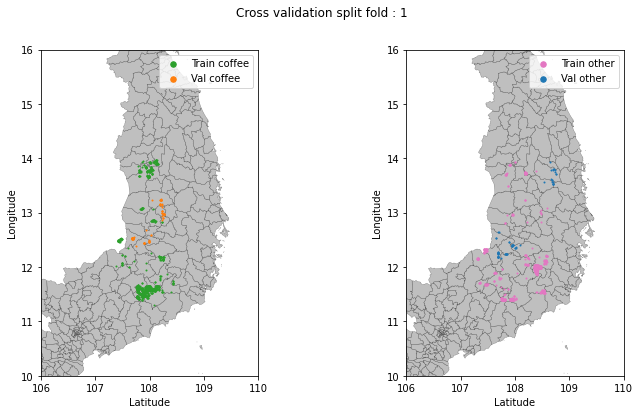

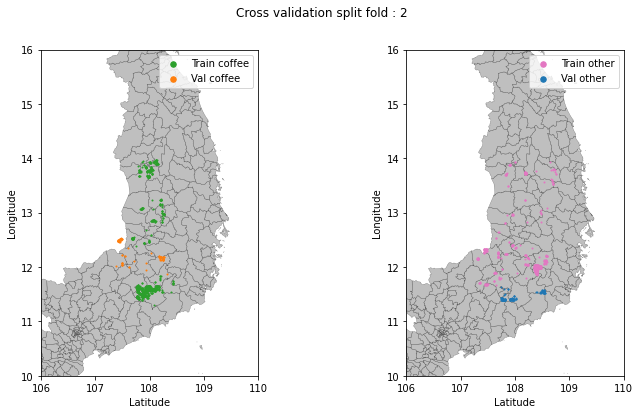

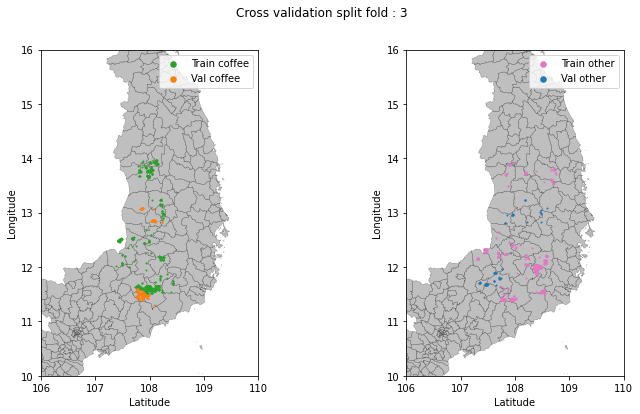

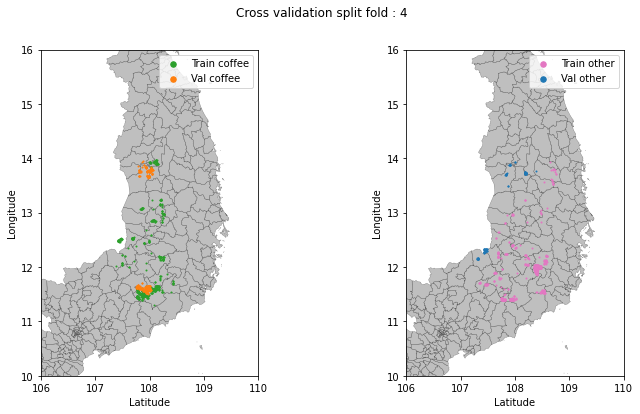

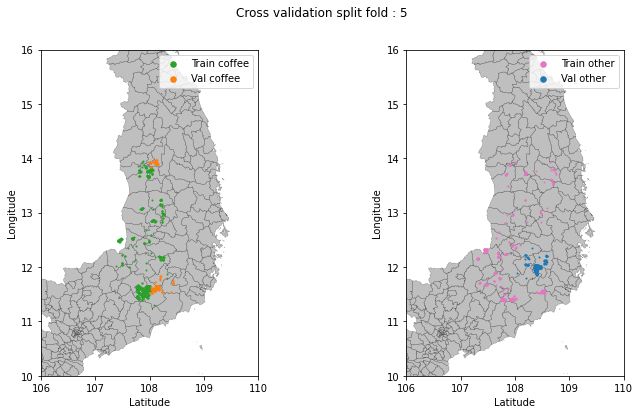

In [16]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold_2",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold_2",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, 
                                geo_val, 
                                vietnam, 
                                f"Cross validation split fold : {i_fold+1}",
                                legend1=["Train culture", "Val culture"],
                                legend2=["Train no-culture", "Val no-culture"])
    
    print(f"Fold {i_fold+1} Number culture - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-culture - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number culture - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-culture - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=len(geo_val)//BATCH_SIZE,
                        callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [12]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [13]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.8203125
Stdev accuracy : 0.07578527695486109


Mean loss : 0.9544264793395996
Stdev loss : 0.33155234196664335


Mean precision : 0.8326960444450379
Stdev precision : 0.18411510042180457


Mean recall : 0.8273696541786194
Stdev recall : 0.12824341369446576


Mean F1-Score : 0.8068888425827027
Stdev F1-Score : 0.1163907260064288


## Loss and accs plots

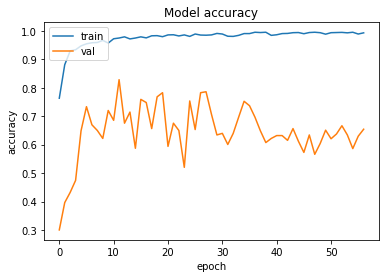

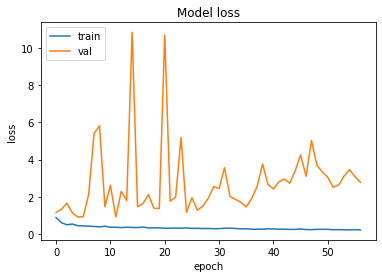

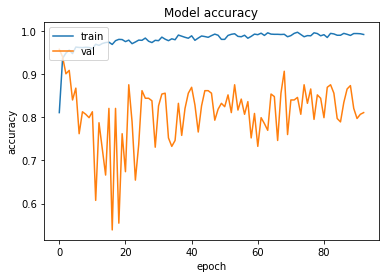

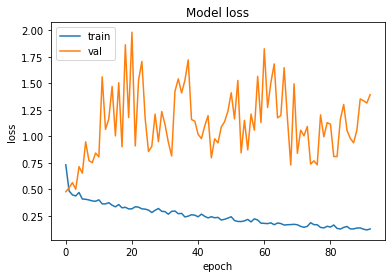

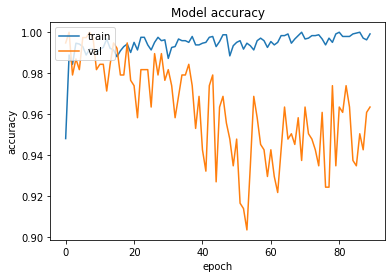

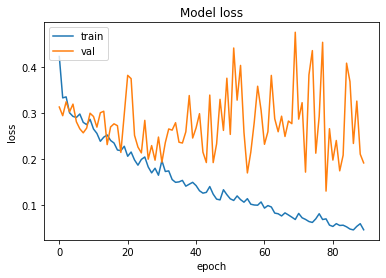

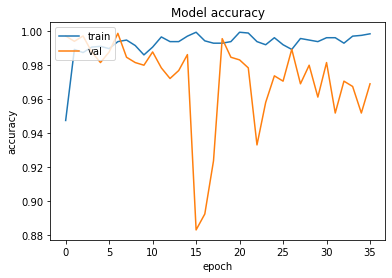

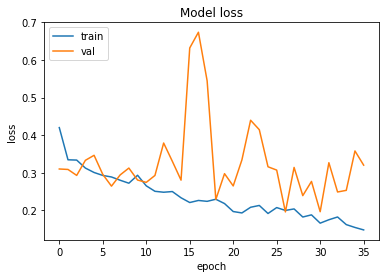

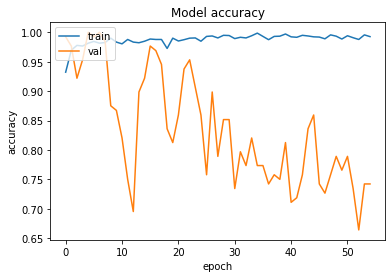

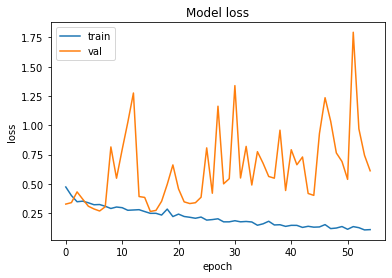

In [14]:
a = os.path.join(SAVED_MODELS_PATH, 'Culture', 'final_spacv_10FOLD_culture_1')
for i in os.listdir(a):
    if(i.split('.')[1] == 'npy'):
        chart = np.load(os.path.join(a, i), allow_pickle=True).item()
        
        # summarize history for accuracy
        plt.plot(chart['accuracy'])
        plt.plot(chart['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(chart['loss'])
        plt.plot(chart['val_loss'])
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()